<a href="https://colab.research.google.com/github/lohaoxi/basic-pytorch-gans/blob/master/01_vanilla_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import math

import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision.models import inception_v3

if not os.path.exists('visuals'):
    os.mkdir('visuals')

In [ ]:
BATCH_SIZE = 32
K = 8
N_EPOCHS = 512
NOISE_DIM = 100
IMAGE_DIM = 28*28
MAXOUT_SIZE = 5
HIDDEN_DIM = (1200, 625)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)

data_train = torchvision.datasets.MNIST(
    "./data/mnist", 
    train=True, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        FlattenTransform()
        ])
    )

loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
    )

In [ ]:
print("Number of observation: {0}".format(len(data_train)))
print("Size of each observation: {0}".format(np.array(data_train[0][0]).shape))

Number of observation: 60000
Size of each observation: (1, 784)


In [ ]:


class Maxout(nn.Module):

    def __init__(self, n_pieces):
        super(Maxout, self).__init__()
        self.n_pieces = n_pieces
        
    def forward(self, batch):
        assert batch.shape[1] % self.n_pieces == 0
        batch = batch.view(
            batch.shape[0], 
            batch.shape[1] // self.n_pieces, 
            self.n_pieces
            )
        batch, _ = batch.max(dim=2)
        return batch
    

class Generator(nn.Module):

    def __init__(self, noise_dim, hid_dim, out_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.fc1 = nn.Linear(self.noise_dim, self.hid_dim, bias=True)
        self.fc2 = nn.Linear(self.hid_dim, self.hid_dim, bias=True)
        self.fc3 = nn.Linear(self.hid_dim, self.hid_dim, bias=True)
        self.fc4 = nn.Linear(self.hid_dim, self.out_dim, bias=True)

    def forward(self, batch):

        batch = F.dropout(F.relu(self.fc1(batch)))
        batch = F.dropout(F.relu(self.fc2(batch)))
        batch = F.dropout(F.relu(self.fc3(batch)))
        batch = torch.sigmoid(self.fc4(batch))

        return batch


class Discriminator(nn.Module):

    def __init__(self, in_dim, hid_dim, out_dim, maxout_size):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.maxout_size = maxout_size
        self.Maxout = Maxout(maxout_size)

        self.fc1 = nn.Linear(self.in_dim, self.hid_dim, bias=True)
        self.fc2 = nn.Linear(self.hid_dim // self.maxout_size, self.hid_dim, bias=True)
        self.fc3 = nn.Linear(self.hid_dim // self.maxout_size, self.out_dim, bias=True)

    def forward(self, batch):
        batch = batch.view(batch.size(0), -1)
        batch = self.Maxout(self.fc1(batch))
        batch = self.Maxout(self.fc2(batch))
        batch = torch.sigmoid(self.fc3(batch))
        
        return batch

In [ ]:
generator = Generator(NOISE_DIM, HIDDEN_DIM[0], IMAGE_DIM).to(device)
discriminator = Discriminator(IMAGE_DIM, HIDDEN_DIM[1], 1, MAXOUT_SIZE).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters in the Generatoris: {}".format(count_parameters(generator)))
print("Number of parameters in the Discriminator: {}".format(count_parameters(discriminator)))

Number of parameters in the Generatoris: 3945184
Number of parameters in the Discriminator: 569501


In [ ]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(16, NOISE_DIM).to(device)

num_steps = len(loader_train) // BATCH_SIZE

discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.0002,
    momentum=0.5
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.0002,
    momentum=0.5
)

criterion = torch.nn.BCELoss()

In [ ]:
   
for epoch in range(N_EPOCHS):

    D_loss = 0
    G_loss = 0
    D_x = 0
    D_g_z1 = 0
    D_g_z2 = 0

    for i, (images, _) in enumerate(loader_train):

        if i == num_steps: break

        # Train Discriminator

        for _ in range(K):
            
            real_images = images.to(device) # [batch_size, 784]

            fake_images = generator(torch.randn(BATCH_SIZE, NOISE_DIM).to(device)) # [batch_size, 784]

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images)

            discriminator_err_real = criterion(real_outputs, real_labels)
            discriminator_err_fake = criterion(fake_outputs, fake_labels)

            discriminator_err_real.backward()
            discriminator_err_fake.backward()

            discriminator_optimizer.step()

        # Train Generator
        z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z))

        generator_err = criterion(outputs, real_labels)

        generator_err.backward()

        generator_optimizer.step()

        # Loss calculation
        D_loss += (discriminator_err_real + discriminator_err_fake).item()
        G_loss += generator_err.item()
        D_x += real_outputs.mean().item()
        D_g_z1 += fake_outputs.mean().item()
        D_g_z2 += outputs.mean().item()

    print("epcoh: {}\t D_loss: {:.4f}\t G_loss: {:.4f}\t D_x: {:.4f}\t D_g_z1: {:.4f}\t D_g_z2: {:.4f}\t".format(
        str(epoch).zfill(6), 
        D_loss / num_steps / K,
        G_loss / num_steps,
        D_x / num_steps / K,
        D_g_z1 / num_steps / K,
        D_g_z2 / num_steps
    )
    )

    if epoch % 10 == 0:

        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image(
            generated,
            os.path.join(
                'visuals',
                '{}.jpg'.format(
                    str(epoch).zfill(6)
                )
            ),
            nrow=4,
            padding=10,
            pad_value=1
        )


epcoh: 000000	 D_loss: 0.1377	 G_loss: 1.2100	 D_x: 0.0602	 D_g_z1: 0.0382	 D_g_z2: 0.3052	
epcoh: 000001	 D_loss: 0.1010	 G_loss: 1.7840	 D_x: 0.0672	 D_g_z1: 0.0212	 D_g_z2: 0.1694	
epcoh: 000002	 D_loss: 0.0703	 G_loss: 2.2327	 D_x: 0.0800	 D_g_z1: 0.0135	 D_g_z2: 0.1082	
epcoh: 000003	 D_loss: 0.0452	 G_loss: 2.6831	 D_x: 0.0937	 D_g_z1: 0.0086	 D_g_z2: 0.0689	
epcoh: 000004	 D_loss: 0.0286	 G_loss: 3.1291	 D_x: 0.1042	 D_g_z1: 0.0055	 D_g_z2: 0.0441	
epcoh: 000005	 D_loss: 0.0191	 G_loss: 3.5366	 D_x: 0.1107	 D_g_z1: 0.0037	 D_g_z2: 0.0293	
epcoh: 000006	 D_loss: 0.0131	 G_loss: 3.8869	 D_x: 0.1150	 D_g_z1: 0.0026	 D_g_z2: 0.0206	
epcoh: 000007	 D_loss: 0.0098	 G_loss: 4.1848	 D_x: 0.1175	 D_g_z1: 0.0019	 D_g_z2: 0.0153	
epcoh: 000008	 D_loss: 0.0076	 G_loss: 4.4388	 D_x: 0.1191	 D_g_z1: 0.0015	 D_g_z2: 0.0118	
epcoh: 000009	 D_loss: 0.0061	 G_loss: 4.6561	 D_x: 0.1202	 D_g_z1: 0.0012	 D_g_z2: 0.0095	
epcoh: 000010	 D_loss: 0.0049	 G_loss: 4.8480	 D_x: 0.1211	 D_g_z1: 0.0010	 D_g_

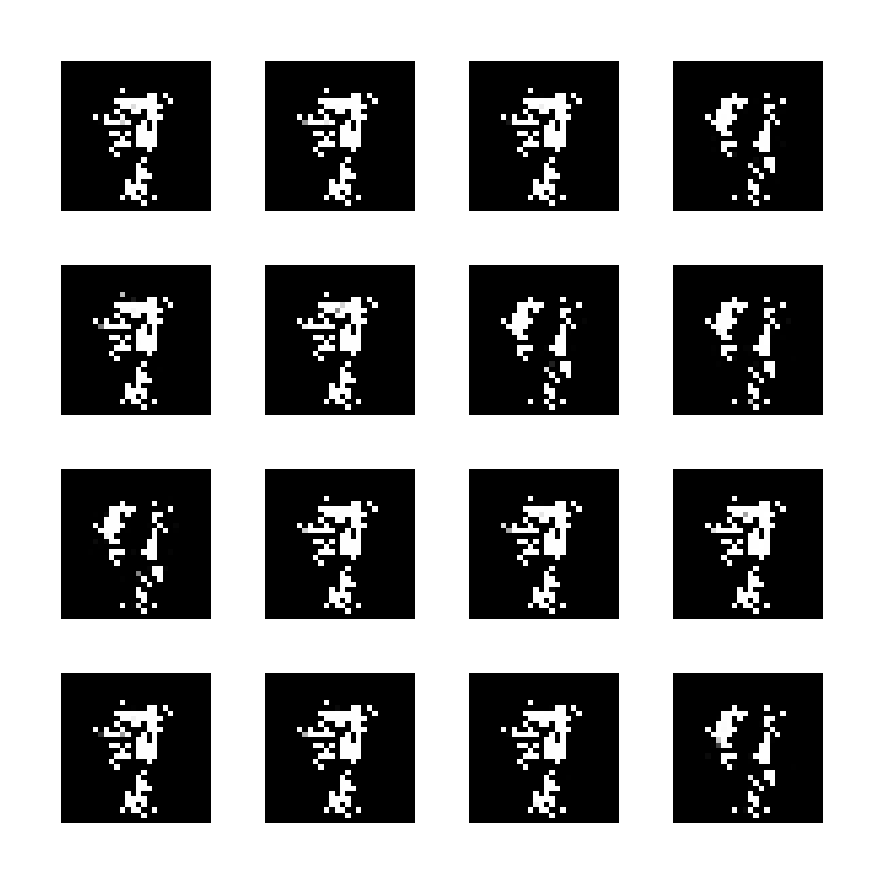

In [ ]:
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);

In [ ]:
def calc_inception_score(images, batch_size):

    # initialize pretrained inception network
    net = inception_v3(pretrained=True).to(device)

    # list of scores
    scores = []

    # number of steps
    num_steps = int(math.ceil(float(len(images)) / float(batch_size)))

    # iterate over the images
    for i in range(num_steps):

        # mini-batch start and end index
        s = i * batch_size
        e = (i + 1) * batch_size

        # mini-batch images
        mini_batch = images[s:e]
        
        # mini-batch as Torch tensor with gradients
        batch = Variable(mini_batch)

        # apply a forward pass through inception network
        # skipping aux logits
        '''
        This network is unique because it has two output layers when training.
        The second output is known as an auxiliary output and is contained in the AuxLogits part of the network.
        The primary output is a linear layer at the end of the network.
        Note, when testing we only consider the primary output.
        '''
        s, _ = net(batch)

        # accumulate scores
        scores.append(s)
    
    # stack scores as tensor
    scores = torch.cat(scores, 0)

    # calculate inception score

    '''
    The formula for inception score
    IS(x) = E[ KL( P(y|x) || P(y)) ]
    x: generated images
    y: inception model classification distribution aka softmax
    '''

    # calculate p(y|x) across dimension 1
    # that is one row for each image
    p_yx = F.softmax(scores, 1)

    # calculate p(y) across dimension 0
    # that is one column for each class / label
    p_y = p_yx.mean(0).unsqueeze(0).expand(p_yx.size(0), -1)

    # calculate KL divergence
    KL_d = p_yx * (torch.log(p_yx) - torch.log(p_y))

    # calculate mean aka expected of KL
    final_score = KL_d.mean()

    # return final score
    return final_score

In [ ]:
# inception v3 feature extractor
class PartialInceptionNetwork(nn.Module):
  
  def __init__(self):
      # trigger parent constructor
      super(PartialInceptionNetwork, self).__init__()

      # initialize pretrained network
      self.inception_network = inception_v3(pretrained=True)
      
      # register a forward hook otherwise not implemented exception is raised
      self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)

  # register hook to allow forward pass on second to last block
  def output_hook(self, module, input, output):
      # N x 2048 x 8 x 8
      self.mixed_7c_output = output

  def forward(self, x):
      """
      Args:
          x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
      Returns:
          inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
      """
      assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                            ", but got {}".format(x.shape)

      # Trigger output hook
      self.inception_network(x)

      # Output: N x 2048 x 8 x 8 
      activations = self.mixed_7c_output

      # Output: N x 2048 x 1 x 1 
      activations = torch.nn.functional.adaptive_avg_pool2d(
          activations, (1,1))

      # Rectify dimensions
      activations = activations.view(x.shape[0], 2048)

      return activations

def calc_fid_score(real_images, gen_images, batch_size):

    # initialize pretrained inception network
    net = PartialInceptionNetwork().to(device)

    # list of features
    real_activations = []
    gen_activations = []

    # number of steps
    num_steps = int(math.ceil(float(len(real_images)) / float(batch_size)))

    # iterate over the images
    for i in range(num_steps):

        # mini-batch start and end index
        s = i * batch_size
        e = (i + 1) * batch_size

        # mini-batch images
        mini_batch_real = real_images[s:e]
        mini_batch_gen = gen_images[s:e]
        
        # mini-batch as Torch tensor with gradients
        batch_real = Variable(mini_batch_real)
        batch_gen = Variable(mini_batch_gen)

        # apply a forward pass through inception network
        features_real = net(batch_real)
        features_gen = net(batch_gen)

        # accumulate features
        real_activations.append(features_real)
        gen_activations.append(features_gen)
    
    # stack tensor
    features_real = torch.cat(real_activations, 0)
    features_gen = torch.cat(gen_activations, 0)

    # tensor to numpy
    xr = features_real.detach().cpu().numpy()
    xg = features_gen.detach().cpu().numpy()

    # calculate mean
    u1 = np.mean(xr, axis=0)
    u2 = np.mean(xg, axis=0)

    # calculate variance
    s1 = np.cov(xr, rowvar=False)
    s2 = np.cov(xg, rowvar=False)

    # difference squared
    diff = u1 - u2
    diff_squared = diff.dot(diff)

    # trace covariance product
    prod = s1.dot(s2)
    sqrt_prod, _ = scipy.linalg.sqrtm(prod, disp=False)
    
    # avoid imaginary numbers
    if np.iscomplexobj(sqrt_prod):
        sqrt_prod = sqrt_prod.real

    prod_tr = np.trace(sqrt_prod)

    # calculate FID
    final_score = diff_squared + np.trace(s1) + np.trace(s2) - 2 * prod_tr

    # return final score
    return final_score

In [ ]:
def resize_images(imgs):
    imgs = imgs.view(-1, 1, 28, 28)

    # repeat Gray channel to RGB
    imgs = imgs.repeat(1, 3, 1, 1)

    # resize the images to 3x299x299
    res_imgs = F.interpolate(imgs, size=(299, 299))

    return res_imgs

def calc_scores(imgs_real, 
                imgs_fake, 
                batch_size):

    res_imgs_real = resize_images(imgs_real)
    res_imgs_fake = resize_images(imgs_fake)

    # calculate inception score
    inception_score_real = calc_inception_score(res_imgs_real, BATCH_SIZE).item()
    inception_score_fake = calc_inception_score(res_imgs_fake, BATCH_SIZE).item()

    # calculate FID score
    fid_score = calc_fid_score(res_imgs_real, res_imgs_fake, BATCH_SIZE)

    return inception_score_real, inception_score_fake, fid_score

scores = calc_scores(
    imgs_real=next(iter(loader_train))[0].to(device), 
    imgs_fake=generator(test_set), 
    batch_size=BATCH_SIZE
    )


print("Real Inception score: {}".format(scores[0]))
print("Fake Inception score: {}".format(scores[1]))
print("FID score: {}".format(scores[2]))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Real Inception score: 0.0006210809224285185
Fake Inception score: 0.00034659559605643153
FID score: 123.66990310356746
